In [50]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
npPath = '../../../../../sharedData/scratch/npOut/G16_data_04_08-19/'
ncPath = '../../../../../sharedData/scratch/'
import re
import os
from os import path as op
import numpy as np

In [51]:
day = '098'
SS = '16'
band = '08'
ncList = os.listdir( ncPath )
npList = os.listdir( npPath )

look = 'M6C'+ band + '_G' + SS + '_s2019' + day
ncFiles = sorted([f for f in ncList if re.search(look,f)])
npFiles = sorted([f for f in npList if re.search(look,f)])



In [52]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [75]:
Tmean = []
times = []
for ncf, npf in zip(ncFiles,npFiles):
    imageBox = np.load(op.join(npPath,npf))
    myFile = xr.open_dataset(op.join(ncPath,ncf))
    planck_fk1 = float(myFile['planck_fk1'].data)
    planck_fk2 = float(myFile['planck_fk2'].data) 
    planck_bc1 = float(myFile['planck_bc1'].data)                       
    planck_bc2 = float(myFile['planck_bc2'].data)     
    T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
    tString = ncf[34:38]
    times.append(tString)
    Tmean.append(T)
    

In [76]:
print(Tmean)
print(time)

[245.71106955953917, 245.7022881170302, 245.6878393949753, 245.6779811259085, 245.6623006635893, 245.64972956170897, 245.62817558084913, 245.61731639801027, 245.5965681699393, 245.5774738427989, 245.5607828415959, 245.54065299657273, 245.51382313628906, 245.48711180792498, 245.4633499350016, 245.43605175480968, 245.4060245898437, 245.38157111781547, 245.3517588347173, 245.32803713189773, 245.28742995926714, 245.26287906650848, 245.23553025573122, 245.20203538701102, 245.17494368239525, 245.14108810302005, 245.11739130300845, 245.0972567130119, 245.0222039338188, nan, 245.0740616952295, 245.0554760068414, 245.03399666243223, 244.974940303158, 244.9524347466859, 244.92469298623297, 244.89892533850318, 244.8703571540012, 244.8298709631321, 244.78980558037983, 244.7500941590443, 244.70856423862614, 244.6706045594639, 244.62560500490176, 244.59612073015896, 244.56383044273085, 244.53254590827942, 244.49739162398956, 244.48254094975186, 244.46432195997932, 244.4465733825985, 244.422691292927

In [82]:
from datetime import datetime

ptimes = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times]

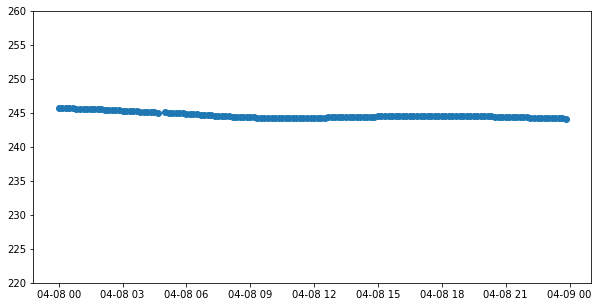

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.plot_date(ptimes, Tmean)
_ = ax.set_ylim(220,260)

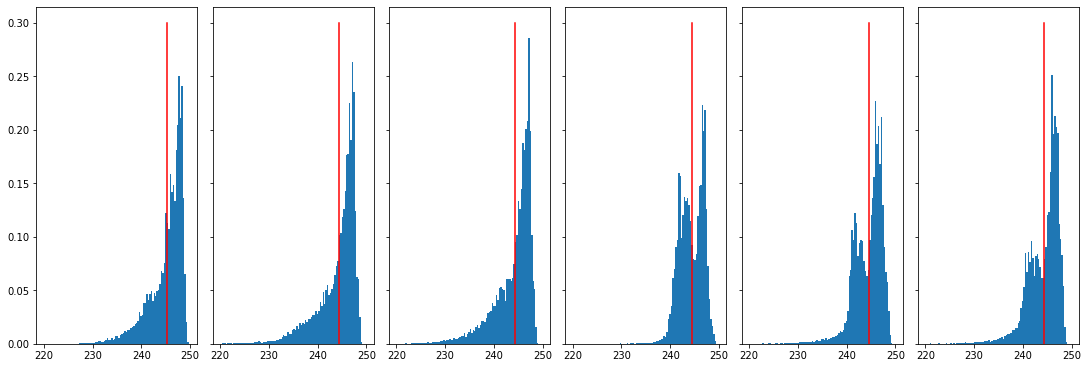

In [101]:
Tmean = []
times = []
toi = ['0300','0910','1010','2100','1510','1350']

bins = np.linspace(220,250,101)
fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), constrained_layout=True, sharey = True, sharex = True)
for ncf, npf in zip(ncFiles,npFiles):
    imageBox = np.load(op.join(npPath,npf))
    myFile = xr.open_dataset(op.join(ncPath,ncf))
    planck_fk1 = float(myFile['planck_fk1'].data)
    planck_fk2 = float(myFile['planck_fk2'].data) 
    planck_bc1 = float(myFile['planck_bc1'].data)                       
    planck_bc2 = float(myFile['planck_bc2'].data)     
    T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
    tString = ncf[34:38]
    times.append(tString)
    Tmean.append(T)

    
    if tString in toi:
        ax = axes[toi.index(tString)]
        Tbox = Rad2BT(imageBox, planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        ax.hist(Tbox.ravel(), bins = bins, density = True)
        ax.plot([T,T], [0,0.3],'r')

In [91]:
a=[12.34,66, 77]


In [92]:
a.index(12.34)

0

array([220. , 220.3, 220.6, 220.9, 221.2, 221.5, 221.8, 222.1, 222.4,
       222.7, 223. , 223.3, 223.6, 223.9, 224.2, 224.5, 224.8, 225.1,
       225.4, 225.7, 226. , 226.3, 226.6, 226.9, 227.2, 227.5, 227.8,
       228.1, 228.4, 228.7, 229. , 229.3, 229.6, 229.9, 230.2, 230.5,
       230.8, 231.1, 231.4, 231.7, 232. , 232.3, 232.6, 232.9, 233.2,
       233.5, 233.8, 234.1, 234.4, 234.7, 235. , 235.3, 235.6, 235.9,
       236.2, 236.5, 236.8, 237.1, 237.4, 237.7, 238. , 238.3, 238.6,
       238.9, 239.2, 239.5, 239.8, 240.1, 240.4, 240.7, 241. , 241.3,
       241.6, 241.9, 242.2, 242.5, 242.8, 243.1, 243.4, 243.7, 244. ,
       244.3, 244.6, 244.9, 245.2, 245.5, 245.8, 246.1, 246.4, 246.7,
       247. , 247.3, 247.6, 247.9, 248.2, 248.5, 248.8, 249.1, 249.4,
       249.7, 250. ])